

#ASI assessed exercice


---

**Rayene Harkati**

---
To make this notebook work you have to upload your credetials kaggle json file 



##Data preparation

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm.notebook import tqdm
import jax
import jax.numpy as jnp
from functools import partial
from typing import NamedTuple
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from google.colab import drive

In [49]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c santander-customer-transaction-prediction
! unzip santander-customer-transaction-prediction.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
santander-customer-transaction-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  santander-customer-transaction-prediction.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# **A**
 
 Download and import the Santander dataset. The labels of the test data are not publicly available, so create your own test set by randomly choosing half of the instances in the
original training set. 


In [50]:
#Download the dataset
data = pd.read_csv("train.csv")

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [46]:
data.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [51]:
#Creating the dataframe of features
X = data.dropna().iloc[:,2:202].values
#Creating the dataframe of the label
Y = data["target"].dropna().values

In [52]:
#Creating the train and test data 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1, test_size=0.5)
print("######## Training and Testing datasets ##########")

print('The shape of X_train : ' , X_train.shape)
print('The shape of X_test : ' , X_test.shape)

######## Training and Testing datasets ##########
The shape of X_train :  (100000, 200)
The shape of X_test :  (100000, 200)


# **B**

Comment on the distribution of class labels and the dimensionality of the input and how
these may affect the analysis.

In [53]:
#Dimensionality
print("The number of samples:",len(data))
print("The number of columns :",len(data.columns),",including the target and the index")

The number of samples: 200000
The number of columns : 202 ,including the target and the index


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  


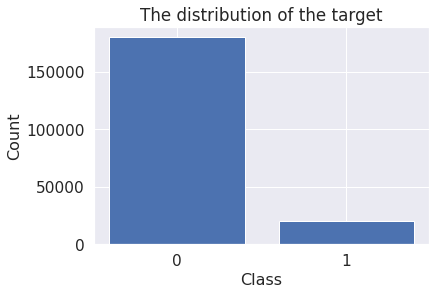

Imbalanced Dataset :  10.049 % of ones and  89.95100000000001 % of zeros


In [54]:
label_1 = len(data[data['target'] == 1])
label_0 = len(data[data['target'] == 0])

classes = ['0','1']

plt.bar(classes,[label_0,label_1],color='br',edgecolor='white')
plt.xticks(classes)

plt.bar([0,1],[label_0,label_1])
plt.xlabel('Class', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.title('The distribution of the target')
plt.show()

frequency_of_1 = label_1/len(data)
frequency_of_0 = label_0/len(data)

print("Imbalanced Dataset : ", frequency_of_1*100, "% of ones and ",frequency_of_0*100, "% of zeros")

As we can see , we have almost 89.96% samples which have the label  0 and less than 11% samples have the label 1
That means we have an unbalanced data , which will affect the performance of our model : An unbalanced dataset will bias the prediction model towards the more common class which means  poorer generalization  over the minor class 
And also the input has a very large dimension (200 features) which may lead to overfitting.



# 1.Bayesian linear regression 


# **A**
Implement Bayesian linear regression (you should already have an implementation from the lab sessions)

In [55]:
##All the functions needed to do bayesian linear regression from the 1st Lab
# build the design matrix
def lognormal(x, mu, var):
    log_p  = np.log(1/np.sqrt(2*var*np.pi))+(-1/2)*((x-mu)**2/var)
    return log_p

def gaussian_loglik(y, y_tilde, sn2):
    return np.sum(lognormal(y,y_tilde,sn2))

def compute_posterior(X, y, sw2, sn2):
    w_posterior_cov = np.linalg.inv(((1/sn2)*(X.T@X) + (1/sw2)*np.ones((len(X[0]),len(X[0])))))
    w_posterior_mean = (1/sn2)* w_posterior_cov@X.T@y
    return w_posterior_mean, w_posterior_cov
    
def compute_predictive(Xt, w_mean, w_cov, sn2):
    def _compute_predictive_single_point(xt_i, w_mean, w_cov, sn2):
        yt_i_mean = xt_i.T@w_mean
        yt_i_var = sn2 + xt_i.T@w_cov@xt_i
        return yt_i_mean, yt_i_var
    yt_mean, yt_var = np.zeros(len(Xt)), np.zeros(len(Xt))
    for i, xt_i in enumerate(Xt):  # Loop on all the points
        yt_mean[i], yt_var[i] = _compute_predictive_single_point(
            xt_i, w_mean, w_cov, sn2
        )
    return yt_mean, yt_var
    
def sample(Xt, w_mean, w_cov, sn2, N):
    def _sample_single(Xt, w_mean, w_cov, sn2):
        w_tilde = np.random.multivariate_normal(w_mean,w_cov,1)[0]
        y_sample = Xt@w_tilde 
        y_sample = y_sample + np.random.normal(0, sn2, y_sample.shape)
        return y_sample

    samples = np.zeros((N, len(Xt)))
    for i in range(N):
        samples[i] = _sample_single(Xt, w_mean, w_cov, sn2)
    return samples

def bayesian_linear_regression(X, y, Xt, sn2, sw2):
    w_posterior_mean, w_posterior_cov =  compute_posterior(X, y, sw2, sn2)
    y_mean, y_var =  compute_predictive(Xt, w_posterior_mean, w_posterior_cov, sn2)
    samples =  sample(Xt, w_posterior_mean, w_posterior_cov, sn2, 2)
    return y_mean, y_var, samples

# **B**
Describe any pre-processing that you suggest for this data

To clean and organize the data to be suitable for a building and training Machine Learning models , we should do so :

-1 Identifying and handling the missing values in our data (if there are ),we can do so in two ways : either deleting the rows containing missing values in given features  (which is not always the best sollution)or compute the mean of the corresponding column and fill the missing values  appearing in this column  with its mean .The second method can add variance to the dataset, and any loss of data can be efficiently negated. Hence, it yields better results compared to the first method . 

-2 Compute the features importance ,ordering them acording to their variance and drop the ones which have low variance. 

-3 We perform the scaling  in case where the difference between the max value and the min value of a given feature is so high to standardize them whitin a  specific range. In other words, feature scaling limits the range of variables so that we can compare them on common grounds.(I will implement it too in this assessed exercice )

-4 Balancing the data (the one I will try to implement  in this assessed exercice ) : to avoid the biased learning 

 **Scaling the data**

In [56]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**Data balancing**

In [57]:
def balancing_data(df):
    threshold = 0.113
    datab = df[(np.random.rand(data.shape[0]) < threshold) | (data["target"] == 1)]

    ones = len(datab[datab['target'] == 1])
    zeros = len(datab[datab['target'] == 0])

    classes = ['0','1']

    plt.bar(classes,[zeros,ones],color='blue',edgecolor='black')
    plt.xticks(classes)

    plt.bar([0,1],[zeros,ones])
    plt.xlabel('Class', fontsize=16)
    plt.ylabel('Count', fontsize=16)
    plt.title("Imbalance of the two classes")
    plt.show()
    frequency_of_1 = ones/len(datab)
    frequency_of_0 = zeros/len(datab)
    print("Imbalanced Dataset : ", frequency_of_1*100, "% of ones and ",frequency_of_0*100, "% of zeros")
    #ASSIGNMENT
    X = datab.drop('target', axis=1)
    X = X.drop('ID_code' , axis=1)
    #Creating the dataframe of the target
    Y = datab.target
    X_tr, X_tes, Y_tr, Y_tes = train_test_split(X, Y, test_size=0.5)
  #TRANSFORMATION TO ARRAYS
    X_tr=X_tr.values
    X_tes=X_tes.values
    Y_tr=Y_tr.values
    Y_tes=Y_tes.values


    return X_tr, X_tes, Y_tr, Y_tes

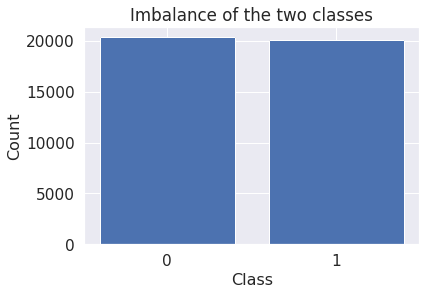

Imbalanced Dataset :  49.65779655572851 % of ones and  50.34220344427149 % of zeros


In [58]:
Balanced_X_train, Balanced_X_test, Balanced_Y_train, Balanced_Y_test=balancing_data(data)

# C 
Treat class labels as continuous and apply regression to the training data. Also, calculate and report the posterior variance of the weights

#1-with unbalanced data 

In [59]:
w_posterior_mean, w_posterior_cov = compute_posterior(X_train, Y_train, 1, 1)
yt_mean ,yt_var,samples =bayesian_linear_regression(X_train, Y_train, X_test, 1,1) 

In [60]:
print('Bayesian Linear Regression results shapes')
print('posterior mean :',w_posterior_mean.shape,'\n posterior variance:',w_posterior_cov.shape,'\n y mean :',yt_mean.shape,'\n y variance:',yt_var.shape,'\n outputs :',samples.shape)

Bayesian Linear Regression results shapes
posterior mean : (200,) 
 posterior variance: (200, 200) 
 y mean : (100000,) 
 y variance: (100000,) 
 outputs : (2, 100000)


In [61]:
print('The posterior mean ')
w_posterior_mean

The posterior mean 


array([ 1.40328214e-02,  1.31815135e-02,  1.35168177e-02,  2.42302740e-03,
        4.22933385e-03,  6.99086395e-03,  1.66853401e-02, -4.89265575e-04,
        3.99308263e-03, -9.19878246e-03, -6.05302328e-04,  5.23489370e-03,
       -1.75512047e-02, -1.31577793e-02, -1.55862819e-03,  4.99506654e-03,
        1.31668765e-03, -4.48137153e-05,  9.48925859e-03,  3.05241446e-03,
       -4.71595469e-03, -1.38978988e-02,  1.36724104e-02, -8.63154907e-03,
        7.42087776e-03,  3.05509800e-03,  1.54977663e-02,  5.10683590e-04,
       -5.59161895e-03,  2.84145407e-03,  9.75784154e-05, -6.61250867e-03,
        6.74895549e-03, -1.22077365e-02, -1.28846218e-02,  9.53439969e-03,
       -1.04045344e-02,  2.49719681e-03,  3.46019676e-04, -1.82135295e-04,
        1.21865873e-02, -1.20935899e-03, -2.18952158e-03, -7.16966388e-03,
       -1.22421907e-02, -5.63367099e-03,  1.28582776e-03,  2.03799595e-03,
        8.05184001e-03,  7.43078423e-03, -4.62785650e-03,  5.50551032e-03,
        7.00718692e-03,  

In [62]:
print('posterior covariance ')
w_posterior_cov

posterior covariance 


array([[ 1.00284668e-05,  2.50185177e-08, -6.30328722e-08, ...,
        -3.21063485e-08,  6.53765630e-08, -8.22346126e-08],
       [ 2.50185177e-08,  1.00235279e-05, -2.11095023e-08, ...,
         7.23094549e-08,  4.55032185e-08, -1.38308376e-08],
       [-6.30328722e-08, -2.11095023e-08,  1.00302490e-05, ...,
         4.37247698e-08,  2.38907133e-08, -6.59251548e-08],
       ...,
       [-3.21063485e-08,  7.23094549e-08,  4.37247698e-08, ...,
         1.00213123e-05, -2.15052068e-08, -7.10089541e-09],
       [ 6.53765630e-08,  4.55032185e-08,  2.38907133e-08, ...,
        -2.15052068e-08,  1.00265402e-05,  4.95682923e-08],
       [-8.22346126e-08, -1.38308376e-08, -6.59251548e-08, ...,
        -7.10089541e-09,  4.95682923e-08,  1.00205024e-05]])

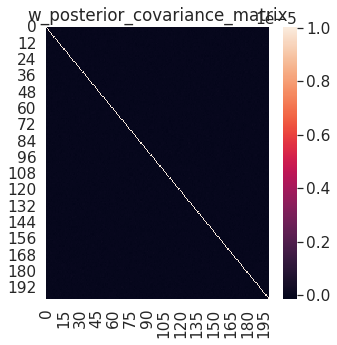

In [63]:
plt.figure(figsize=(5,5))
sns.heatmap(w_posterior_cov)
plt.title('w_posterior_covariance_matrix')
plt.show()

There is  low covariance between the different variances 


# 2-With balanced data 

In [64]:
w_posterior_mean_balanced, w_posterior_cov_balanced = compute_posterior(Balanced_X_train,Balanced_Y_train, 1, 1)
yt_mean_balanced ,yt_var_balanced,samples_balanced=bayesian_linear_regression(Balanced_X_train,Balanced_Y_train, Balanced_X_test, 1,1) 

In [65]:
print('Bayesian Linear Regression results shapes')
print('posterior mean :',w_posterior_mean_balanced.shape,'\n posterior variance:',w_posterior_cov_balanced.shape,'\n y mean :',yt_mean_balanced.shape,'\n y variance:',yt_var_balanced.shape,'\n outputs :',samples_balanced.shape)

Bayesian Linear Regression results shapes
posterior mean : (200,) 
 posterior variance: (200, 200) 
 y mean : (20237,) 
 y variance: (20237,) 
 outputs : (2, 20237)


In [66]:
print('posterior mean for balanced data ')
w_posterior_mean_balanced

posterior mean for balanced data 


array([ 7.18212345e-03,  7.66398452e-03,  9.01640147e-03,  3.46477069e-03,
        5.01653878e-03,  2.67866113e-03,  4.01697530e-02, -7.99419441e-04,
        3.04686150e-03, -1.28071772e-02,  1.59128307e-04,  2.39700439e-03,
       -1.50172071e-01, -5.52638327e-03, -2.03018435e-03,  2.54938154e-02,
        3.26117178e-03, -6.64703984e-05,  2.92836243e-03,  2.14455958e-04,
       -1.68031864e-03, -3.62957272e-03,  1.07067170e-02, -2.52910429e-02,
        4.85771480e-03,  3.51189493e-02,  5.75774784e-03,  7.61955667e-04,
       -2.07679828e-02,  1.75865157e-03,  3.46695454e-04, -5.45222437e-03,
        6.66256486e-03, -5.85019902e-03, -4.89584510e-02,  3.14936559e-03,
       -6.60131057e-03,  2.56483235e-03,  5.91210591e-04, -2.04462796e-04,
        2.85274232e-03, -7.43014953e-04, -1.12445772e-02, -5.02472427e-02,
       -4.05689691e-03, -5.01840995e-04,  1.16344178e-04,  5.71106873e-04,
        1.11254171e-03,  2.01873619e-03, -9.66894002e-03,  1.49039953e-03,
        1.83244307e-03,  

In [67]:
print('posterior covariance for balanced data ')
w_posterior_cov_balanced

posterior covariance for balanced data 


array([[ 5.00872849e-06, -1.23796718e-08, -2.36376374e-08, ...,
         6.18223404e-08,  1.68169340e-08, -9.46588384e-09],
       [-1.23796718e-08,  2.97040524e-06, -2.59130132e-08, ...,
         9.10985477e-08,  3.86283289e-08, -5.91360501e-09],
       [-2.36376374e-08, -2.59130132e-08,  6.70695083e-06, ...,
        -1.47991161e-07, -2.14557163e-08, -1.68551925e-08],
       ...,
       [ 6.18223404e-08,  9.10985477e-08, -1.47991161e-07, ...,
         5.67921365e-05, -9.67492569e-09,  1.52839220e-08],
       [ 1.68169340e-08,  3.86283289e-08, -2.14557163e-08, ...,
        -9.67492569e-09,  5.15573586e-06, -1.51588581e-10],
       [-9.46588384e-09, -5.91360501e-09, -1.68551925e-08, ...,
         1.52839220e-08, -1.51588581e-10,  4.59683906e-07]])

# **D**

 Suggest a way to discretize predictions and display the confusion matrix on the test data and report accuracy

We can fix a treshold and then we assign to the predicted labels which are bigger than this treshold the target 1 and the others (lesser than the treshold )the target 0, I will do that for the balanced and unmbalanced data 

#1_Unbalanced data

I will choose the threshold which keeps for me the characterestics of the data ( zeros more than ones (90%), The metrics I will be using to choose the best treshold are the loss(that should be minimized ) and the AUC score that should be maximized


In [68]:
def result_analysis(y_predicted,y):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_predicted)):
        if(y_predicted[i] == 1 and y[i] == 1):
            TP += 1
        if(y_predicted[i] == 0 and y[i] == 1):
            FN += 1
        if(y_predicted[i] == 1 and y[i] == 0):
            FP += 1
        else:
            TN += 1
            
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    # Sensitivity, hit rate, recall, or true positive rate
    se = TP / (TP + FN )
    # Specificity or true negative rate
    sp = TN / (TN + FP )

    error_rate = 1 - accuracy
        
    auc_score = roc_auc_score(y, y_predicted)
        
    return TP, TN, FP, FN, accuracy, error_rate, se, sp, auc_score


In [69]:
def evaluate(y_predicted,y):
    
    TP, TN, FP, FN, accuracy, error_rate, se, sp, auc = result_analysis(y_predicted,y)
            
    confusion_matrix = [[FP,TP],[TN,FN]]
    df_cm = pd.DataFrame(confusion_matrix, [1,0], [0,1])
    sns.set(font_scale=1.4) # for label size
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    
    plt.xlabel("True values")
    plt.ylabel("Predicted values")
    plt.title("Confusion Matrix (Bayesian linear Regression Case)")
    
    plt.show()
    
    print("accuracy : ",accuracy)
    print("error rate : ", error_rate)
    print("Sensitivity : ", se)
    print("Specificity : ", sp)
    print("AUC : ", auc)

In [70]:
threshold = np.sort(yt_mean)[91000]
y_hat = np.where(yt_mean > threshold , 1, 0)

In [99]:
from sklearn.metrics import roc_auc_score
def classification_of_result_rate (y_predic,y_test) :
    errorr=0
    well_classified = 0
    difference = np.array(y_predic)-np.array(y_test)
    for i in range(len(difference)):
       if difference[i]==0:
            well_classified  = well_classified+1
       else:
            errorr = errorr +1
    return errorr,well_classified

In [104]:
error,well_classified=classification_of_result_rate(y_hat,Y_test)
print('error:',error,'\n welll classified : ',well_classified)

error: 9702 
 welll classified :  90298


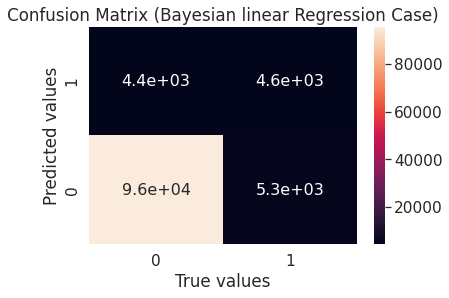

accuracy :  0.9117767411408462
error rate :  0.08822325885915383
Sensitivity :  0.46474776852873334
Specificity :  0.95635
AUC :  0.708131695636258


In [73]:
evaluate(y_hat,Y_test)

#2-Balanced data

I will fix the treshold to 0.5 since we have 49% of ones qnd 51% of zeros 

In [74]:
y_hatb = np.where(yt_mean_balanced >= 0.5 , 1, 0)

In [75]:
error_balanced,well_classified_balanced=classification_of_result_rate(y_hatb,Balanced_Y_test)
print('error:',error_balanced,'\n welll classified : ',well_classified_balanced)

error: 4500 
 welll classified :  15737


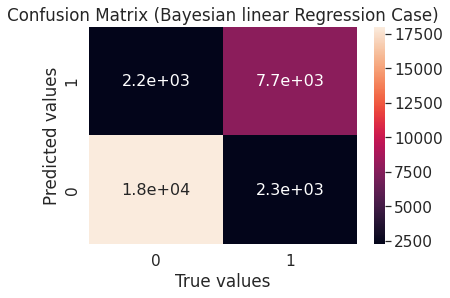

accuracy :  0.8510870644296634
error rate :  0.14891293557033658
Sensitivity :  0.7740933680625125
Specificity :  0.8890645846716411
AUC :  0.7775878834461758


In [76]:
evaluate(y_hatb,Balanced_Y_test)

# 2.Logistic linear regression

# **A**
implement a Markov chain Monte Carlo inference algorithm to infer parameters 

In [77]:
def logistic(z):
    return 1/(1+np.exp(-z))

def bernoulli_density(y, p):
  return  (1-y)*np.log(1-p) + y*np.log(p)

def gaussian_density(x, mean=0, var=1):
    return - .5 * np.log(2 * np.pi * var) - .5 * (x - mean)**2 / var 

def logposterior(w, X, y):
    p = logistic(X@w)
    final = np.sum(bernoulli_density(y, p)) + -(1/(2*20))*w.T.dot(w)
    return final 

def rw_mh_step(w_prev, step_size):
    w_s = np.random.normal(w_prev, step_size, 200)
    r = logposterior(w_s, X_train, Y_train)-logposterior(w_prev, X_train, Y_train)
    r = np.exp(r)
    if r>=1:
      return w_s
    else:
      u= random.uniform(0, 1)
      if u <= r :
        return w_s
      else :
        return w_prev

def run_sampling(w, n_samples, step_size=0.5):
    w = np.atleast_1d(w)
    samples = np.empty((n_samples, *w.shape))
    for i in range(n_samples):
        w = rw_mh_step(w, step_size)
        samples[i] = w
    return samples

def predict_MH(X_test, samples):
    X_test = np.atleast_2d(X_test)
    return 1 / samples.shape[0] * np.sum(logistic(samples @ X_test.T), axis=0)

# **B**
Implement the variational approximation we studied in the course to obtain an
 approximation to the posterior over model parameters

I will assume that the posterior and prior distributions have a diagonal covariance matrix for simplicity reasons 

In [78]:
def bernoulli_density(y, p):
    return (1-y) * jnp.log(1-p+1e-10) + y * jnp.log(p+1e-10)

class GaussianDiagonal(NamedTuple):
    mean: jnp.array
    log_var: jnp.array

def sample_gaussian_diagonal(rng, params):
    mean, log_var = params
    var = jnp.exp(log_var)
    sigma = jnp.sqrt(var)
    eps = jax.random.normal(key=rng, shape=sigma.shape) 
    return mean + sigma * eps 

def kl_diag_diag(q_params, p_params):
    assert isinstance(q_params, GaussianDiagonal)
    assert isinstance(p_params, GaussianDiagonal)
    mean_q, log_var_q = q_params
    mean_p, log_var_p = p_params
    var_q = jnp.exp(log_var_q)
    var_p = jnp.exp(log_var_p)
    kl = 1/2 * jnp.sum((log_var_p - log_var_q)+ ((var_q + jnp.square(mean_q - mean_p)) / var_p) - 1)
    return kl

def logistic(z):
    return 1/(1+jnp.exp(-z))
def model(w, X):
    return logistic(X@w)

def create_elbo_fn(sample_fn, likelihood_fn, kl_divergence_fn):
    """Create a function to compute the ELBO, given the function to sample
    from the posterior, the likelihood function and the KL divergence
    """

    @partial(jax.vmap, in_axes=[0, None, None, None])
    def likelihood_sample_fn(rng, q_params, X, y):
        """Compute the likelihood with one Monte Carlo sample of the posterior
        The function is decorated to vectorize multiple MC samples automatically
        """
        # Get one sample of w using the sample_fn and the parameters of q
        w = sample_fn(rng, q_params)
        # Predict the output using the sample before
        yp = model(w,X)
        # Compute the likelihood and return it
        return likelihood_fn(y,yp)

    def elbo_fn(q_params, p_params, rng, X, y, Nmc=10):
        """Computes the ELBO with multiple samples"""
        # Split the random seed in Nmc times
        rng = jax.random.split(rng, Nmc)
        # Compute the values of the likelihood
        likelihood_vals = likelihood_sample_fn(rng, q_params, X, y)
        # Compute the expectation (i.e. take the mean)
        expected_likelihood = jnp.mean(jnp.sum(likelihood_vals,axis=1))
        # Compute the KL divergence
        kl = kl_divergence_fn(q_params,p_params) 
        # Compute the ELBO
        elbo = expected_likelihood - kl
        # Return the ELBO and its two term (used later for logging)
        return elbo, (expected_likelihood, kl)

    return elbo_fn

def sg_update(params, gradients, learning_rate=1e-3):
    updated_params = jax.tree_map(lambda p, g: p + learning_rate * g, params, gradients)
    return updated_params

def predict_y(sample_fn, q_params, Xt, rng, Nmc=10): 
    def predict_y_single(rng):
        w = sample_fn(rng, q_params)
        yp = model(w, Xt)
        return yp
    rng = jax.random.split(rng, Nmc)
    Xt = jnp.atleast_1d(Xt)
    yp = jax.vmap(predict_y_single)(rng)
    yp = np.mean(yp, axis=0) 
    return yp

# **C**

 Based on samples from the posterior over model parameters, write a function
that computes the predictive distribution, and write the necessary functions to evaluate
classification metrics such as the log-likelihood on test data and error rate

In [79]:
def compute_MH(X_test,n_samples = 1000,step_size = 1e-4):
    w_init = np.zeros(200)
    samples = run_sampling(w_init, n_samples=n_samples,  step_size=step_size)
    y_hat = predict_MH(X_test,samples)
    return y_hat

def compute_variational_approx(X_train,Y_train,X_test,steps,lr,Nmc):
    elbo_fn = create_elbo_fn(
    sample_fn= sample_gaussian_diagonal,
    kl_divergence_fn = kl_diag_diag,
    likelihood_fn=bernoulli_density
    )
    rng = jax.random.PRNGKey(0)
    q_params = GaussianDiagonal(jnp.zeros(200), jnp.zeros(200))
    p_params = GaussianDiagonal(jnp.zeros(200), jnp.zeros(200))
    grad_elbo_fn = jax.grad(elbo_fn, has_aux=True)
    grad_elbo_fn = jax.jit(grad_elbo_fn, static_argnames=("Nmc"))
    elbo_summary = []
    lik_summary = []
    kl_summary = []
    for i in tqdm(range(steps), desc="Training ELBO"):
        rng, rng2 = jax.random.split(rng)
        q_params_grad, (likelihood, kl) = grad_elbo_fn(q_params, p_params, rng2, X_train, Y_train, Nmc=Nmc)# @@ COMPLETE @@ #
        q_params = sg_update(q_params,q_params_grad, learning_rate=lr) # @@ COMPLETE @@ #
        lik_summary.append(likelihood)
        kl_summary.append(kl)
        elbo_summary.append(likelihood - kl)
    yp = predict_y(sample_gaussian_diagonal, q_params, X_test, rng, Nmc=Nmc)
    return yp , elbo_summary,lik_summary,kl_summary

In [80]:
def log_likelihood(y, p):
    ll = (1-y) * np.log(1-p+1e-10) + y * np.log(p+1e-10)
    return np.mean(ll)

In [81]:
def gaussian_loglik(y, y_tilde, sn2=1):
    return np.sum(lognormal(y,y_tilde,sn2))

In [83]:
from sklearn.metrics import log_loss
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
def logistic_evaluation_metrics(y,y_predicted) : 
    ##Confuion matrix
    evaluate(y_predicted,y)
    ## Performance Metrics
    print('Evaluation Metrics for testing:')
    print('Precision: %.3f' %precision_score(y, y_predicted))
    print('Recall: %.3f'%recall_score(y, y_predicted))
    print('F1 Score: %.3f' %f1_score(y, y_predicted))
    print('Accuracy: %.3f'%accuracy_score(y, y_predicted))


    ##Log likelihood
    print("log likelihood", log_likelihood(y,y_predicted))
   # Gaussian liklehood 
    print("gaussian likelihood", gaussian_loglik(y,y_predicted))
    ##error rate
    print("error rate",  1 - accuracy_score(y, y_predicted))

#Using Metropolis Hasting

# 1 Unbalanced data

In [84]:
y_hat_metropolis_hasting= compute_MH(X_test,n_samples = 2000,step_size = 1e-4)
threshold = np.sort(y_hat_metropolis_hasting)[91000]
y_metropolis_hasting = np.where(y_hat_metropolis_hasting > threshold , 1, 0)

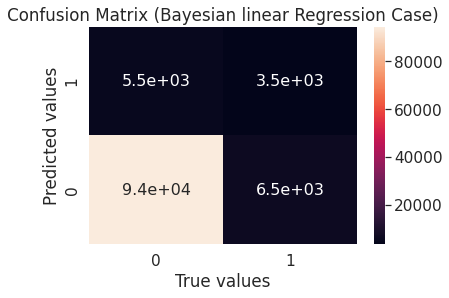

accuracy :  0.890389284447718
error rate :  0.10961071555228197
Sensitivity :  0.3468057366362451
Specificity :  0.94459
AUC :  0.6426294508637468
Evaluation Metrics for testing:
Precision: 0.384
Recall: 0.347
F1 Score: 0.365
Accuracy: 0.879
log likelihood -2.7755360710070764
gaussian likelihood -97920.85332046724
error rate 0.12053999999999998


In [85]:
logistic_evaluation_metrics(Y_test,y_metropolis_hasting)

In [86]:
error_metropolis_hasting,well_classified_metropolis_hasting=classification_of_result_rate(y_metropolis_hasting,Y_test)
print('error:',error_metropolis_hasting,'\n welll classified : ',well_classified_metropolis_hasting)

error: 12054 
 welll classified :  87946


# 2 Balanced data 


In [87]:
count=0
for i in range(len(Balanced_Y_test)):
  if Balanced_Y_test[i]==0:
    count+=1
count

10255

In [88]:
y_hat_metropolis_hasting_balanced= compute_MH(Balanced_X_test,n_samples = 2000,step_size = 1e-4)
threshold = np.sort(y_hat_metropolis_hasting_balanced)[10249]
y_hat_metropolis_hasting_balanced = np.where(y_hat_metropolis_hasting_balanced > threshold , 1, 0)

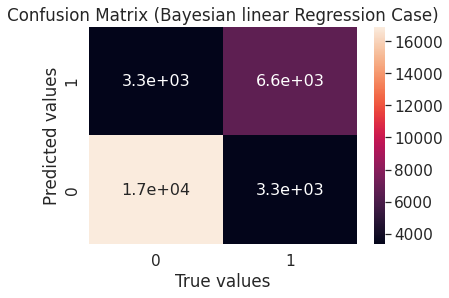

accuracy :  0.7791786624309209
error rate :  0.22082133756907907
Sensitivity :  0.6659987978361049
Specificity :  0.8350051885160844
AUC :  0.6702007641057658
Evaluation Metrics for testing:
Precision: 0.666
Recall: 0.666
F1 Score: 0.666
Accuracy: 0.670
log likelihood -7.592602819298133
gaussian likelihood -21933.05909646296
error rate 0.3297425507733359


In [89]:
logistic_evaluation_metrics(Balanced_Y_test,y_hat_metropolis_hasting_balanced)

In [90]:
error_metropolis_hasting_balanced,well_classified_metropolis_hasting_balanced=classification_of_result_rate(y_hat_metropolis_hasting_balanced,Balanced_Y_test)
print('error:',error_metropolis_hasting_balanced,'\n welll classified : ',well_classified_metropolis_hasting_balanced)

error: 6673 
 welll classified :  13564


# Prediction Using Variational Inference

# for umbalanced data

In [91]:
yp,elbo_summary,lik_summary,kl_summary = compute_variational_approx(X_train,Y_train,X_test,500,lr = 1e-6,Nmc=400)

Training ELBO:   0%|          | 0/500 [00:00<?, ?it/s]

In [92]:
threshold = np.sort(yp)[91000]
y_VA = np.where(yp > threshold , 1, 0)

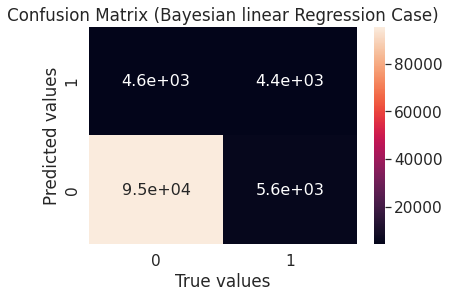

accuracy :  0.90692091551409
error rate :  0.09307908448590996
Sensitivity :  0.4379701133286531
Specificity :  0.95368
AUC :  0.6932600125118868
Evaluation Metrics for testing:
Precision: 0.485
Recall: 0.438
F1 Score: 0.460
Accuracy: 0.898
log likelihood -2.3569261010989413
gaussian likelihood -97011.85332046724
error rate 0.10236


In [93]:
logistic_evaluation_metrics(Y_test,y_VA)

In [94]:
error_VA,well_classified_VA=classification_of_result_rate(y_VA,Y_test)
print('error:',error_VA,'\n welll classified : ',well_classified_VA)

error: 10236 
 welll classified :  89764


-# **D**
The tuning of the Metropolis-Hastings algorithm

The choice of hyperparameters of variational inference algorithm is too important. IN the begining and by setting 1e-7 as a learning rate, initializing the prior and posterior parameters by only 1 and choosing 400 MC samples, the model just learned to predict 1 every time with same variance and mean.  initializing the prior and posterior parameters with 0, the model  converged well and give NaN values for the converged posterior parameters.

  the params concerned are :The number of weights sampled to make predictions,  step size  : a small step size seems to allow us to add new weights more often , a large step size, is less likely to accept the weights of the new samples. In fact, the step size affects the output error rate. We need to make it low enough to ensure to convergence and avoid divergence, and also high enough to converge quickly.


 - The starting point which has a huge impact on the weights sampled. I tried 2 different starting points: the null and the ones . The null w_init was the one that gave better results (the one initialized with 1 predict 1 for all input points) with a 10000 samples.

To guarantee that samples are representative of the posterior over model parameters we could run multiple iterations of MH on different independent chains and verify that it converges each time. I used the burn-in trick we did in the lab. Due to the high dimensionality, I didn't visualize the path of the chains to ensure the representativity of samples. A solution to this problem is to print the rhats score instead.

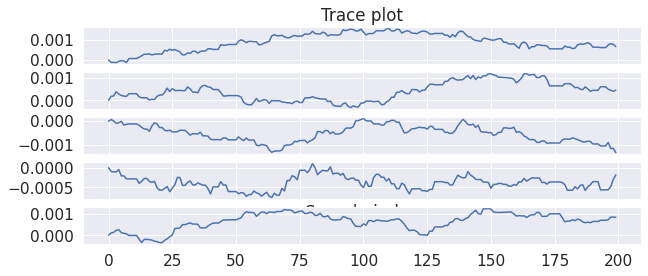

In [95]:
w_init = np.zeros(200)
samples = run_sampling(w=w_init, n_samples=200,  step_size=0.0001)
fig, (ax0, ax1,ax2,ax3,ax4) = plt.subplots(5, 1, figsize=[10, 4], sharex=True)
ax0.plot(list(range(0, samples.shape[0])), samples[:, 1])
ax1.plot(list(range(0, samples.shape[0])), samples[:, 2])
ax2.plot(list(range(0, samples.shape[0])), samples[:, 3])
ax3.plot(list(range(0, samples.shape[0])), samples[:, 4])
ax4.plot(list(range(0, samples.shape[0])), samples[:, 5])
ax0.set_title("Trace plot")
ax3.set_xlabel(r"Sample index")
plt.show()

# **E**
  Comment on the tuning of the variational inference algorithm, and discuss the behavior of the optimization with respect to the choice of the optimizer/step-size


We approximate the ELBO by using a mini-batching. 
or use low value for the number of MC samples. 
As mentioned in the lab, reducing the number of MC samples allow to scale the Variational Inference method on a large dataset. 

During the lab, we updated the posterior parameters by using SGD. I used the same optimizer in the variational inference part. Unlike Adam, SGD optimizer has fixed learning rate, so once again we need to carefully and appropriately set the learning rate. From my implementations, the learning hould be very low in order to avoid the NaN values for the converged posterior parameters. At the same time, it should be high enough to ensure reasonable training time. Overall, I chosed 1e-10 as the learning rate for the run with null parameters and 1e-7 in the other setting. The NaN values were probably obtained du to a gradient explosion problems. .

# F 
 Report the error metrics implemented in point 2.B. above and the confusion matrix on the test data. Discuss logistic regression performance with respect to the performance of Bayesian linear regression. 


The logistic regression performance appears to be worse than the bayesian linear regression performance since the bayesian linear regression has the lowest error rate. And taking into consideration that bayesian linear regression is the fastest and the cheapest in terms of computation cost. Linear regression seems to be best suited for our case.

# unbalanced

**Error Comparaison**

the bayesian linear regression applied on the given dataset scaled has the lowest error rate.then the VA and finaly the metropolis hasting one 

<BarContainer object of 3 artists>

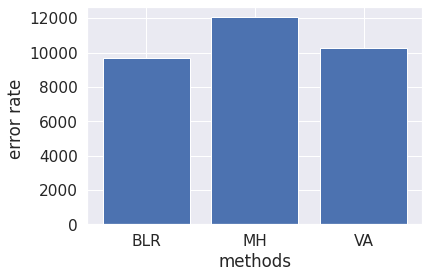

In [108]:
plt.ylabel("error rate ")
plt.xlabel("methods")
plt.bar(["BLR","MH","VA"],[error,error_metropolis_hasting,error_VA],width = 0.8,tick_label = ["BLR","MH","VA"])

**Log liklehood comparison**

By comparing the Metropolis Hasting and Variational Inference algorithms in terms of log likelihood, it seems that the Variational Inference approximation is better. It has the highest log likelihood with prediction on the given dataset scaled.

Overall the performance results obtained shows that making prediction by using the given dataset without balancing is better.

<BarContainer object of 2 artists>

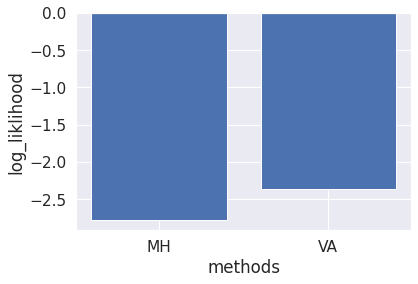

In [109]:
plt.ylabel("log_liklihood")
plt.xlabel("methods")
plt.bar(["MH","VA"],[log_likelihood(Y_test,y_metropolis_hasting),log_likelihood(Y_test,y_VA)],width = 0.8,tick_label = ["MH","VA"])

I will use the variational inference model since it has the better log liklehood and lowest error comapred to MH ( I won't use the BLr for performance and complexity reasons )

In [110]:
print("The gaussian loglikelihood for Blr is :", gaussian_loglik(Y_test, y_hat))

The gaussian loglikelihood for Blr is : -96744.85332046724


#G

Compare the uncertainties on predictions obtained by the Metropolis-Hastings algorithm and variational inference. First, compare the log-likelihood on test data as aglobal metric to assess which inference method yields better uncertainty quantification. Second, pick a few test points for which the mean of the predictive distribution for Metropolis-Hastings is (a) around 0.5 (b) giving a correct prediction (c) giving a wrong prediction, and visualize/discuss what the predictive distribution looks like. Discuss the difference between the Metropolis-Hastings algorithm and variational inference.


First, we should mention that the likelihood used for the BLR is different from the likelihood used for the MH and VA methods for gaussian loglikelihood, and for the second we used the bernoulli density.

The MH method offers a lower likelihood than the VA method , the BLR has the lowest likelihood but we use a different likelihood for it, so I believe there is no point in comparing its value with the logistic regression likelihood.

---



# Unbalanced 

In [111]:
predictions_MH = [y for y in y_hat_metropolis_hasting if 0.45 < y < 0.55]
predictions_VA = [y for y in yp if 0.45 < y < 0.55]

[]

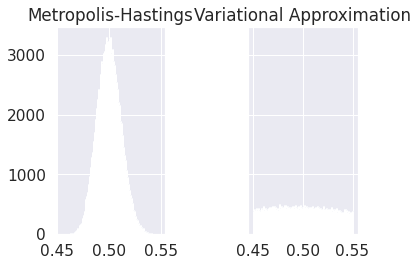

In [112]:
n_bins = 100
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(predictions_MH, bins=n_bins)
axs[0].title.set_text('Metropolis-Hastings')
axs[1].hist(predictions_VA, bins=n_bins)
axs[1].title.set_text('Variational Approximation')
plt.plot()

the metropolis hasting test points arround 0.5 distribution have a bell shape meanwhile the Variational Approximation test point distribution is uniform.

---

b) test points for which the mean of the predictive distribution giving a correct prediction.

In [113]:
correct_predictions_mh = [y_hat_metropolis_hasting[i] for i in range(len(y_hat_metropolis_hasting)) if y_metropolis_hasting[i] == Y_test[i]]
correct_predictions_vi = [yp[i] for i in range(len(yp)) if y_VA[i] == Y_test[i]]
print('correct_predictions_mh',correct_predictions_mh,'\n correct_predictions_vi',correct_predictions_vi)

correct_predictions_mh 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[]

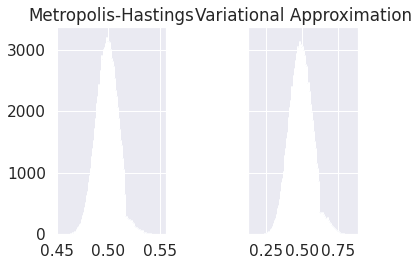

In [114]:
n_bins = 100
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].title.set_text('Metropolis-Hastings')
axs[0].hist(correct_predictions_mh, bins=n_bins)
axs[1].title.set_text('Variational Approximation')
axs[1].hist(correct_predictions_vi, bins=n_bins)
plt.plot()

For the correct predictions, Variational Inference and Metropolis Hasting have approximatively same distribution that is superposition or concatenation of two normal distributions with same mean (both centered on O.5) and lower variance for the Metropolis Hasting.

Now let's test points for which the mean of the predictive distribution giving a correct prediction.

In [116]:
incorrect_predictions_mh = [y_hat_metropolis_hasting[i] for i in range(len(y_hat_metropolis_hasting)) if y_hat_metropolis_hasting[i] != Y_test[i]]
incorrect_predictions_vi = [yp[i] for i in range(len(yp)) if y_VA[i] != Y_test[i]]
print('incorrect_predictions_mh',correct_predictions_mh,'\n incorrect_predictions_vi',incorrect_predictions_vi)

incorrect_predictions_mh 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[DeviceArray(0.459119, dtype=float32), DeviceArray(0.70131284, dtype=float32), DeviceArray(0.64337945, dtype=float32), DeviceArray(0.6508381, dtype=float32), DeviceArray(0.57059366, dtype=float32), DeviceArray(0.39834294, dtype=float32), DeviceArray(0.6515776, dtype=float32), DeviceArray(0.51353645, dtype=float32), DeviceArray(0.6743236, dtype=float32), DeviceArray(0.62630683, dtype=float32), DeviceArray(0.5803233, dtype=float32), DeviceArray(0.642533, dtype=float32), DeviceArray(0.48125517, dtype=float32), DeviceArray(0.64309025, dtype=float32), DeviceArray(0.6218275, dtype=float32), DeviceArray(0.6350313, dtype=float32), DeviceArray(0.55974376, dtype=float32), DeviceArray(0.64702195, dtype=float32), DeviceArray(0.5833715, dtype=float32), DeviceArray(0.6100413, dtype=float32), DeviceArray(0.5506693, dtype=float32), DeviceArray(0.5946581, dtype=float32), DeviceArray(0.6638316, dtype=float32), DeviceArray(0.6388408, dtype=float32), DeviceArray(0.6356244, dtype=float32), DeviceArray(0.67

[]

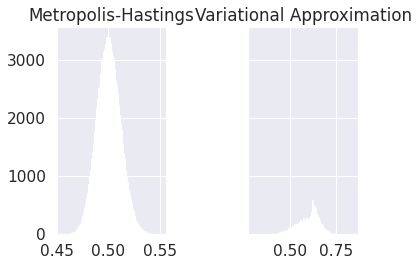

In [117]:
n_bins = 100
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].title.set_text('Metropolis-Hastings')
axs[0].hist(incorrect_predictions_mh, bins=n_bins)
axs[1].title.set_text('Variational Approximation')
axs[1].hist(incorrect_predictions_vi, bins=n_bins)
plt.plot()

Both methods present a agaussian distributions. with a peak around 0.515 for MH method and a peak around 0.62 for VA.
the second one is more uncertain 

The main difference between MH and VA methods is that the Variational approximation method approximates the intractable posterior, while the Metropolis Hasting core idea is to sample from the intractable posterior.

# Bonus

Implement the Laplace approximation and compare the predictive mean and variances with the ones obtained by the other approximations.

In [118]:
def laplace(w, w_map, H):
    detH =  np.linalg.det(H)
    constant = np.sqrt(detH)/(2*np.pi)**(2.0/2.0)
    density = np.exp(-0.5 * (w-w_map).dot(H).dot(w-w_map))
    return constant * density

# Suggest and implement ways to improve performance.

To improve the performance for the bayesian models we need to care more much about the initialization and the hyperparameters tuning part.
